In [862]:
import itertools
import time

from torch.onnx.ops import symbolic

from cirkit.backend.torch.circuits import TorchCircuit
from cirkit.backend.torch.parameters.nodes import TorchTensorParameter
from cirkit.backend.torch.parameters.parameter import TorchParameter
from cirkit.symbolic.io import plot_circuit
from cirkit.templates import data_modalities, utils
from cirkit.pipeline import compile
from notebooks.datasets import sample_rings
import matplotlib.pyplot as plt
import torch
import numpy as np


In [863]:
torch.manual_seed(42)

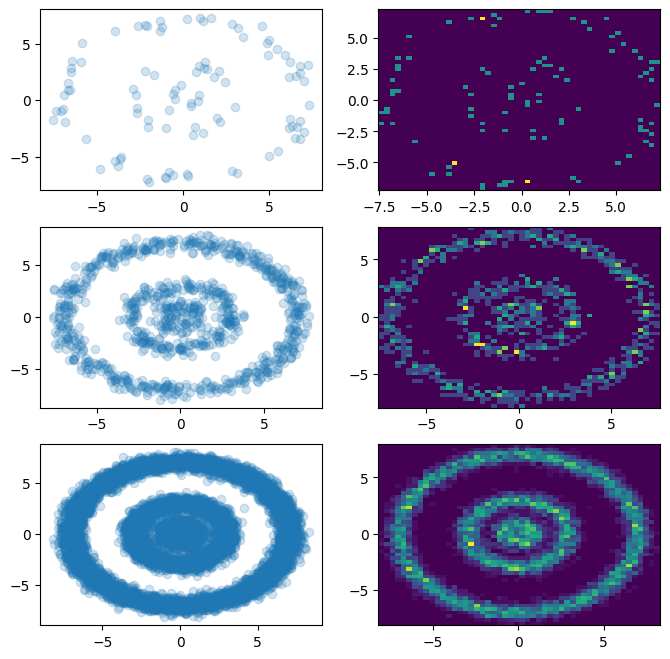

In [864]:
fig, rows = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
for (ax_scat, ax_hist), n in zip(rows, [100, 1_000, 10_000]):
    ring_samples = sample_rings(n, dim=2, radia=[1, 3, 7], sigma=0.4)
    ax_scat.scatter(ring_samples[:, 0], ring_samples[:, 1], alpha=0.2)
    ax_hist.hist2d(ring_samples[:, 0], ring_samples[:, 1], bins=(50, 50))

n = 10_000
ring_samples = sample_rings(n, dim=2, radia=[1, 3, 7], sigma=0.5)
ring_samples = np.float32(ring_samples)

In [865]:
from cirkit.pipeline import PipelineContext
from cirkit.symbolic.circuit import Circuit
from cirkit.utils.scope import Scope
from cirkit.symbolic.layers import GaussianLayer, HadamardLayer, SumLayer, KroneckerLayer

device = torch.device("cpu")
def new_circuit():

    weight_factory = utils.parameterization_to_factory(utils.Parameterization(
        initialization='uniform'
    ))
    mean_factory = utils.parameterization_to_factory(utils.Parameterization(
        initialization='normal',
        initialization_kwargs={"mean": -2, "stddev": 1}
    ))
    stddev_factory = utils.parameterization_to_factory(utils.Parameterization(
        initialization='normal',
        initialization_kwargs={"mean": 2, "stddev": 1}
    ))

    g0 = GaussianLayer(Scope((0,)), 2, mean_factory=mean_factory, stddev_factory=stddev_factory)
    g1 = GaussianLayer(Scope((1,)), 2, mean_factory=mean_factory, stddev_factory=stddev_factory)
    prod = HadamardLayer(num_input_units=2, arity=2)
    sl = SumLayer(2, 1, 1, weight_factory=weight_factory)

    symbolic_circuit = Circuit(
        layers=[g0, g1, prod, sl],
        in_layers={
            g0: [],
            g1: [],
            prod: [g0, g1],
            sl: [prod],
        },
        outputs=[sl]
    )
    pctx = PipelineContext(backend="torch", semiring="lse-sum", fold=True, optimize=False)
    circuit = compile(symbolic_circuit, pctx)
    circuit = circuit.to(device)
    return symbolic_circuit, circuit

symbolic_circuit, circuit = new_circuit()


Number of variables: 2
Structural properties:
 - Smoothness: True
 - Decomposability: True
 - Structured-decomposability: True
Number of layers: 3
Number of learnable parameters: 10



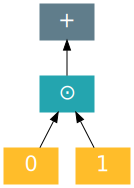

In [866]:
print(f"""
Number of variables: {symbolic_circuit.num_variables}
Structural properties:
 - Smoothness: {symbolic_circuit.is_smooth}
 - Decomposability: {symbolic_circuit.is_decomposable}
 - Structured-decomposability: {symbolic_circuit.is_structured_decomposable}
Number of layers: {len(list(circuit.layers))}
Number of learnable parameters: {sum(p.numel() for p in circuit.parameters())}
""")
plot_circuit(symbolic_circuit)

In [867]:
# from torch import optim
#
# symbolic_circuit, circuit = new_circuit()
# optimizer = optim.Adam(circuit.parameters(), lr=0.01)
# LLs_fullbatch = []
# time_fullbatch = time.time()
# for epoch_idx in range(1000):
#     batch = ring_samples
#     batch = torch.from_numpy(batch).to(device)
#
#     log_likelihoods = circuit(batch)
#
#     loss = -torch.mean(log_likelihoods)
#     loss.backward()
#     optimizer.step()
#     optimizer.zero_grad()
#
#     LLs_fullbatch.append(-loss.detach())
# time_fullbatch = time.time() - time_fullbatch
#
#
# symbolic_circuit, circuit = new_circuit()
# optimizer = optim.Adam(circuit.parameters(), lr=0.01)
# LLs_minibatch = []
# time_minibatch = time.time()
# for epoch_idx in range(100):
#     for i, batch in enumerate(np.vsplit(ring_samples, 10)):
#         batch = torch.from_numpy(batch).to(device)
#
#         log_likelihoods = circuit(batch)
#
#         loss = -torch.mean(log_likelihoods)
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#
#         LLs_minibatch.append(-loss.detach())
# time_minibatch = time.time() - time_minibatch
#
# print(f"Full-batch time: {time_fullbatch * 1000:.0f}ms")
# print(f"Minibatch time: {time_minibatch * 1000:.0f}ms")
#
# plt.plot(np.arange(len(LLs_fullbatch)), LLs_fullbatch, label="Full-batch")
# plt.plot(np.arange(len(LLs_minibatch)), LLs_minibatch, label="Minibatch")
# plt.legend()
# plt.show()

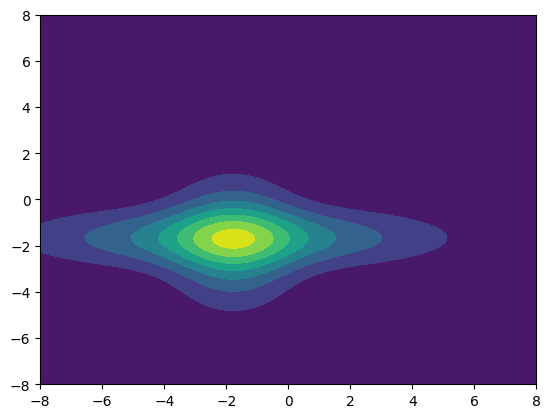

In [868]:
def plot_circuit_distribution_2d(circuit, data=None, ax=plt):
    x = np.float32(np.linspace(-8, 8, 100))
    y = np.float32(np.linspace(-8, 8, 100))

    X, Y = np.meshgrid(x, y)

    xy = itertools.product(x, y)
    xy = torch.tensor(list(xy))
    Z = circuit(xy).detach().exp().numpy().reshape(100, 100)


    ax.contourf(X, Y, Z)
    # ax.colorbar()

    if data is not None:
        ax.scatter(data[:, 0], data[:, 1], color="red", marker="x")

plot_circuit_distribution_2d(circuit)

In [869]:
class AutoGridPlotter:
    def __init__(self, cols=3, rows=3):
        self.fig = plt.figure(figsize=(12, 12))
        self.axs = self.fig.subplots(rows, cols).flatten()
        self.idx = 0
        self.n = len(self.axs)
        self.rows = rows
        self.cols = cols

    def next_ax(self):
        ax = self.axs[self.idx]
        self.idx = self.idx + 1
        ax.title.set_text(f"i={self.idx}")
        if self.idx >= self.n:
            self.show()
            self.fig = plt.figure()
            self.axs = self.fig.subplots(self.rows, self.cols).flatten()
            self.idx = 0
            self.n = len(self.axs)
        return ax

    def show(self):
        self.fig.show()


w_sn_new=tensor([[[0.8854, 0.5739]]])
mean=tensor([[-0.6286,  0.0865],
        [-0.6286,  0.0865]]) var=tensor([[3.2822, 5.4659],
        [3.2822, 5.4659]])
w_sn_new=tensor([[[0.8854, 0.5739]]])
mean=tensor([[-0.8878,  0.5831],
        [-0.8878,  0.5831]]) var=tensor([[6.9022, 4.7091],
        [6.9022, 4.7091]])
w_sn_new=tensor([[[0.8854, 0.5739]]])
mean=tensor([[-1.5389,  1.3476],
        [-1.5389,  1.3476]]) var=tensor([[7.2942, 2.1955],
        [7.2942, 2.1955]])
w_sn_new=tensor([[[0.8854, 0.5739]]])
mean=tensor([[-2.5694,  1.7948],
        [-2.5694,  1.7948]]) var=tensor([[4.8060, 0.2783],
        [4.8060, 0.2783]])
w_sn_new=tensor([[[0.8854, 0.5739]]])
mean=tensor([[-3.1439,  1.7972],
        [-3.1439,  1.7972]]) var=tensor([[2.6476, 0.2366],
        [2.6476, 0.2366]])
w_sn_new=tensor([[[0.8854, 0.5739]]])
mean=tensor([[-3.2680,  1.7841],
        [-3.2680,  1.7841]]) var=tensor([[2.2023, 0.2411],
        [2.2023, 0.2411]])
w_sn_new=tensor([[[0.8854, 0.5739]]])
mean=tensor([[-3.273

/tmp/ipykernel_105367/2848671858.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


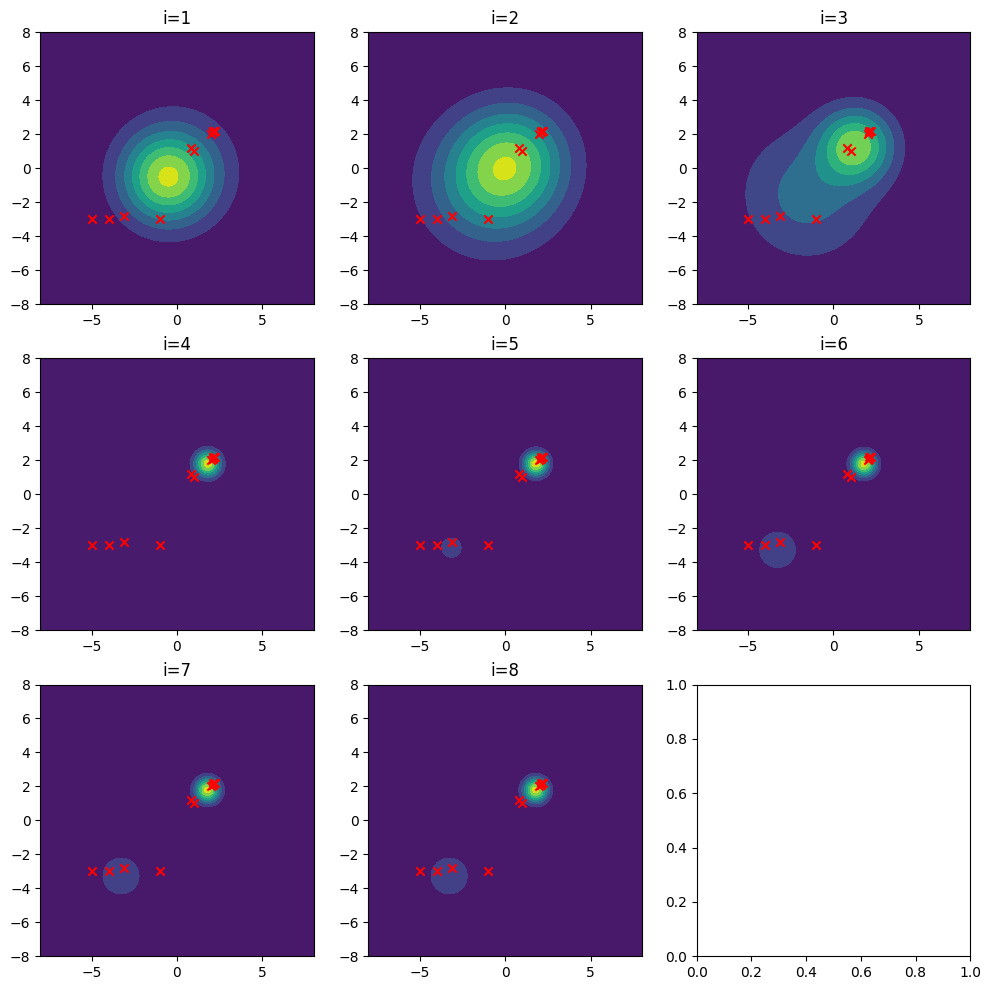

In [870]:
from cirkit.backend.torch.layers import TorchSumLayer, TorchGaussianLayer


def update_params_nested(params: TorchParameter, new_values: torch.Tensor):
    for p in params.outputs:
        if type(p) == TorchTensorParameter:
            p.update_params(new_values.squeeze())

def get_params_nested(params: TorchParameter):
    for p in params.outputs:
        if type(p) == TorchTensorParameter:
            return p()

class FullBatchEM:
    def __init__(self, circuit):
        self.circuit = circuit

        self.sum_layer_weights = {}
        self.leaf_layer_outputs = {}

        self.sum_x_n_sn = {}
        self.total_counts = {}
        self.sum_x_suff_stats_x = {}
        self.sum_x_suff_stats_x_2 = {}
        self.sum_x_p_l = {}

        for l in circuit.modules():
            if isinstance(l, TorchSumLayer):
                self.sum_layer_weights[l] = l.weight
            if isinstance(l, TorchGaussianLayer):
                self.leaf_layer_outputs[l] = None


    def _layer_fn(self, layer, *inputs):
        output = layer(*inputs)
        if isinstance(layer, TorchGaussianLayer):
            output.retain_grad()
            self.leaf_layer_outputs[layer] = output
        return output

    def e_weights(self, log_likelihoods_per_sample):
        for sum_layer, weights in self.sum_layer_weights.items():
            with torch.no_grad():
                n_sn = get_params_nested(weights).grad
                sum_x_n_sn = torch.sum(n_sn, dim=2)
                self.sum_x_n_sn[sum_layer] = sum_x_n_sn

    def m_weights(self):
        for sum_layer, weights in self.sum_layer_weights.items():
            with torch.no_grad():
                w_sn = get_params_nested(weights)
                sum_x_n_sn = self.sum_x_n_sn[sum_layer]

                w_sn_new = w_sn * sum_x_n_sn / sum_x_n_sn.sum()
                w_sn_new_reparam = w_sn_new # torch.softmax(w_sn_new, dim=2)

                print(f"{w_sn_new=}")

                update_params_nested(weights, w_sn_new_reparam)

    def e_leaves(self, log_likelihoods_per_sample, data_full):
        for leaf, outputs in self.leaf_layer_outputs.items():
            with torch.no_grad():
                p_l = outputs.grad

                x = data_full[:,leaf.scope_idx].squeeze()
                x_2 = x ** 2

                sum_x_suff_stats_x = torch.sum(p_l * x, dim=1)
                sum_x_suff_stats_x_2 = torch.sum(p_l * x_2, dim=1)

                sum_x_p_l = torch.sum(p_l, dim=1)

                self.sum_x_suff_stats_x[leaf] = sum_x_suff_stats_x
                self.sum_x_suff_stats_x_2[leaf] = sum_x_suff_stats_x_2
                self.sum_x_p_l[leaf] = sum_x_p_l

    def m_leaves(self):
        for leaf in self.leaf_layer_outputs.keys():
            with torch.no_grad():
                sum_x_suff_stats_x = self.sum_x_suff_stats_x[leaf]
                sum_x_suff_stats_x_2 = self.sum_x_suff_stats_x_2[leaf]
                sum_x_p_l = self.sum_x_p_l[leaf]

                x = sum_x_suff_stats_x / sum_x_p_l
                x_2 = sum_x_suff_stats_x_2 / sum_x_p_l

                mean = x
                var = x_2 - x ** 2
                var = var.clamp(min=1e-9)

                stddev = torch.sqrt(var)

                print(f"{mean=} {var=}")

                update_params_nested(leaf.params["mean"], mean)
                update_params_nested(leaf.params["stddev"], stddev)


    def step(self, data):
        self.circuit.zero_grad()
        log_likelihoods_per_sample = self.circuit.evaluate(data, module_fn=self._layer_fn)
        log_likelihoods_per_sample.sum().backward()
        self.e_weights(log_likelihoods_per_sample)
        self.e_leaves(log_likelihoods_per_sample, data)
        self.m_weights()
        self.m_leaves()
        return log_likelihoods_per_sample.sum()

em = FullBatchEM(circuit)
data = torch.from_numpy(ring_samples)
data = torch.tensor([[1.0, 1.0], [0.8, 1.2], [2.0, 2.0], [2.1, 2.2], [2.2, 2.2], [2.1, 2.1], [-5, -3], [-3.1, -2.8], [-4, -3], [-1, -3]])
em_losses = []
grid_plotter = AutoGridPlotter()
for i in range(8):
    # em.e_step(torch.from_numpy(ring_samples))

    # data = torch.tensor([[1.0, 1.0]])
    # data = torch.from_numpy(ring_samples)
    ll = em.step(data)
    plot_circuit_distribution_2d(circuit, data, ax=grid_plotter.next_ax())
    em_losses.append(ll.detach().numpy())
grid_plotter.show()



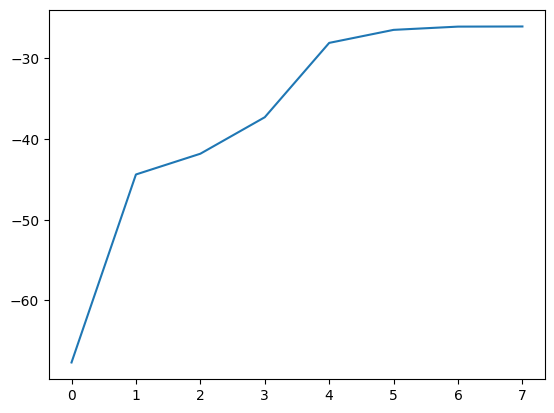

In [871]:
plt.plot(range(len(em_losses)), em_losses)

In [872]:
print("Circuit training mode:", circuit.training)
for name, param in circuit.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

Circuit training mode: True
_nodes.0.mean._nodes.0._ptensor: requires_grad=True
_nodes.0.stddev._nodes.0._ptensor: requires_grad=True
_nodes.2.weight._nodes.0._ptensor: requires_grad=True
